# **Appendix C: 7x7 Lights Out**
---
[![arXiv](https://img.shields.io/badge/arXiv-2106.03157-b31b1b?style=for-the-badge)](https://arxiv.org/abs/2106.03157)
[![GitHub Repository](https://img.shields.io/badge/-Repository-2dba4e?logo=github&style=for-the-badge)](https://github.com/kyo-takano/EfficientCube)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kyo-takano/EfficientCube/blob/main/notebooks/EfficientCube_Lights_Out.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/kyo-takano/EfficientCube/blob/main/notebooks/EfficientCube_Lights_Out.ipynb)

This notebook is intended to demonstrate the proposed method and to allow for reproducible experiments.

As in our paper, the number of training steps ```TrainConfig.num_train_steps``` is set to $10000$.

See paper for theoretical & experimental details.

### **Training & Inference**

The DNN is trained to predict all moves comprising a scramble from the corresponding problem state. \
Since every move is binary in Lights Out, we simply toggle and cancel predicted moves when solving cases.

### **Test**

The trained model is evaluated on [500 test cases provided by Forest Agostinelli, et al. (2019)](https://github.com/forestagostinelli/DeepCubeA/).\
In this notebook, we omit comparison to DeepCubeA result. Although both methods solved all the test cases optimally, ours did so using greedy search (`beam_width=1`).

---
### ***Q. How much time does this notebook take?***

For reference, it took **about 2.5 hours** to run the entire notebook, including training, inference, and comparison.

Computational resources: one 4-core CPU & one GPU ([NVIDIA Tesla P100 PCIe 16GB](https://images.nvidia.com/content/tesla/pdf/nvidia-tesla-p100-PCIe-datasheet.pdf)).

## Setup

Parameters

In [ ]:
# problem
SCRAMBLE_LENGTH = 7*7
# training
class TrainConfig:
    learning_rate = 1e-3
    batch_size_per_depth = 1000
    num_train_steps = 10000
    interval_steps_save = 1000
    interval_steps_plot = 100
    scramble_length = SCRAMBLE_LENGTH

# inference
class SearchConfig:
    ## This can be any number greater than or equal to the Gods Number.
    max_depth = SCRAMBLE_LENGTH * 2
    # beam_width = 1


Modules & Utilities

In [ ]:
#@title
import os
import time
import random
import pickle
import numpy as np
import multiprocessing
from scipy.special import softmax
from copy import deepcopy
from tqdm import tqdm, trange
from IPython.display import clear_output

import torch
from torch import nn
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')
print(f'multiprocessing.cpu_count(): {multiprocessing.cpu_count()}')
!nvidia-smi -L


device: cuda:0
multiprocessing.cpu_count(): 4
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-dc9c1807-5646-970c-0806-366c186349eb)


In [ ]:
#@title
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

mpl.rcParams["axes.prop_cycle"] = cycler(
    color=["#212121", "#2180FE", "#EB4275"])


def plt_history(h):
    fig, axes = plt.subplots(1, 1, figsize=[4, 4])
    axes.plot(h)
    axes.set_xscale("log")
    axes.set_title("Loss")
    plt.show()


def regression_coef(x, y):
    coef = np.array(y) / np.array(x)
    coef = np.mean(np.squeeze(coef))
    return coef


def plot_result(solutions_all, num_nodes_all, times_all):
    fig, ax = plt.subplots(2, 3, figsize=(16, 9))
    ax = ax.ravel()
    for i, result in enumerate([solutions_all, num_nodes_all, times_all]):
        result = [e for e in result if e is not None]
        if i == 0:  # soltions
            result = [len(e) for e in result if e is not None]
            ax[i].axvline(
                np.mean(result),
                color="#00ffff",
                label=f"mean={round(np.mean(result),3)}",
            )
            result = {i: result.count(i)
                      for i in range(min(result), max(result) + 1)}
            ax[i].bar(
                result.keys(),
                result.values(),
                width=1.0,
                label=f"Success: {len([len(e) for e in solutions_all if e is not None])}/{len(solutions_all)}",
            )
            ax[i].legend()
            ax[i].set_xlabel("Solution length")
            ax[i].set_ylabel("Frequency")
        else:
            ax[i].hist(result)
            ax[i].axvline(
                np.mean(result),
                color="#00ffff",
                label=f"mean={round(np.mean(result),3)}",
            )
            ax[i].legend()
            if i == 1:
                ax[i].set_xlabel("No. of nodes")
            else:
                ax[i].set_xlabel("Calculation time (s)")

    solution_lengths, num_nodes, times = [
        [e for e in result if e is not None]
        for result in [solutions_all, num_nodes_all, times_all]
    ]
    solution_lengths = [len(e) for e in solution_lengths]

    for (xlabel, ylabel), (x, y) in [
        [("Solution lengths", "No. of nodes"), (solution_lengths, num_nodes)],
        [("No. of nodes", "Calculation time (s)"), (num_nodes, times)],
        [("Calculation time (s)", "Solution lengths"), (times, solution_lengths)],
    ]:
        i += 1
        ax[i].set_xlabel(xlabel)
        ax[i].set_ylabel(ylabel)
        x_range = np.linspace(0, max(x), 100)
        ax[i].plot(
            x_range,
            x_range * regression_coef(x, y),
            label=f"slope={round(regression_coef(x, y), 5)}",
            color="#00ffff",
        )
        ax[i].scatter(x, y)
        ax[i].legend()

    plt.show()


## Environment: 7x7 LightsOut


In [ ]:
class LightsOut7(object):
    def __init__(self, dim=7):
        self.dtype = np.int64

        # define state and goal
        self.dim = dim
        self.num_tiles = self.dim ** 2
        self.moves_inference = list(range(self.num_tiles))
        self.reset()

        # vectorize the sticker group replacement operations
        self.__vectorize_moves()

    def reset(self):
        self.state = np.zeros((self.num_tiles), dtype=self.dtype)

    def is_solved(self):
        return np.all(self.state == 0)

    def state_to_batch(self):
        return np.expand_dims(self.state, axis=0)

    def finger(self, move):
        self.state[self.move_matrix[move]] = (self.state[self.move_matrix[move]] + 1) % 2 # Take modulo of odd/even to simulate boolean

    def scrambler(self, scramble_length=SCRAMBLE_LENGTH):
        while True:
            self.reset()
            scramble = []
            moves = list(np.random.permutation(scramble_length))
            for i in range(scramble_length):
                move = moves[i]
                self.finger(move)
                scramble.append(move)

                # yield self.state, move
                yield self.state, scramble

    def __vectorize_moves(self):
        self.move_matrix = np.zeros((self.num_tiles, 5), dtype=np.int64)
        for move in range(self.num_tiles):
            x_pos = int(np.floor(move / self.dim))
            y_pos = move % self.dim

            right = move + self.dim if x_pos < (self.dim-1) else move
            left = move - self.dim if x_pos > 0 else move
            up = move + 1 if y_pos < (self.dim - 1) else move
            down = move - 1 if y_pos > 0 else move

            self.move_matrix[move] = [move, right, left, up, down]


env = LightsOut7()


## Model

In [ ]:
class LinearBlock(nn.Module):
    """
    Linear layer with ReLU and BatchNorm
    """
    def __init__(self, input_prev, embed_dim):
        super(LinearBlock, self).__init__()
        self.fc = nn.Linear(input_prev, embed_dim)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(embed_dim)

    def forward(self, inputs):
        x = inputs
        x = self.fc(x)
        x = self.relu(x)
        x = self.bn(x)
        return x


class ResidualBlock(nn.Module):
    """
    Residual block with two linear layers
    """
    def __init__(self, embed_dim):
        super(ResidualBlock, self).__init__()
        self.linearblock_1 = LinearBlock(embed_dim, embed_dim)
        self.linearblock_2 = LinearBlock(embed_dim, embed_dim)

    def forward(self, inputs):
        x = inputs
        x = self.linearblock_1(x)
        x = self.linearblock_2(x)
        x += inputs # skip-connection
        return x


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.one_hot = nn.functional.one_hot
        self.Stack = nn.Sequential(
            LinearBlock(7*7, 5000),
            LinearBlock(5000, 1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
        )
        self.Prediction = nn.Linear(1000, 7*7)

    def forward(self, inputs):
        x = inputs
        x = x.to(torch.float)
        x = self.Stack(x)
        logits = self.Prediction(x)
        return logits


model = Model().to(device)

## Training

In [ ]:
def batch_generator(
        batch_size_per_depth,
        scramble_length=SCRAMBLE_LENGTH,
        n_jobs=multiprocessing.cpu_count(),
    ):
    # setup
    __dtype = np.int64
    batch_size = batch_size_per_depth * scramble_length
    # multiprocessing
    envs = [LightsOut7()] * n_jobs
    generators = [E.scrambler(scramble_length=scramble_length) for E in envs]

    global get_minibatch
    def get_minibatch(i):
        states = np.zeros((scramble_length, 7*7), dtype=__dtype)
        # last_moves = np.zeros((scramble_length, ), dtype=__dtype)
        last_moves = np.zeros((scramble_length, scramble_length), dtype=np.float64)
        g_local = generators[i % n_jobs]
        for j in range(scramble_length):
            _, scramble = next(g_local)
            states[j, :] = envs[i % n_jobs].state 
            last_moves[j, scramble] = 1 / scramble_length
        return states, last_moves

    # create the Pool instance after defining `envs` and `get_minibatch`
    p = multiprocessing.Pool(n_jobs)
    for _ in iter(int, 1):
        ret = p.map(get_minibatch, list(range(batch_size_per_depth)))
        batch_x = np.concatenate([e[0] for e in ret])
        batch_y = np.concatenate([e[1] for e in ret], axis=0)
        yield (batch_x, batch_y)

In [ ]:
def train(config):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    BATCH_SIZE = config.batch_size_per_depth * config.scramble_length
    scramble_length = config.scramble_length
    g = batch_generator(
        batch_size_per_depth=config.batch_size_per_depth,
        scramble_length=config.scramble_length,
    )
    h = []

    for i in trange(1, config.num_train_steps + 1, smoothing=0):
        # prep
        batch_x, batch_y = next(g)
        batch_x, batch_y = torch.from_numpy(batch_x).to(device), torch.from_numpy(
            batch_y
        ).to(device)

        # update
        pred_y = model(batch_x)
        loss = loss_fn(pred_y, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        h.append(loss.item())
        if config.interval_steps_plot and i % config.interval_steps_plot == 0:
            clear_output()
            plt_history(h)
        if config.interval_steps_save and i % config.interval_steps_save == 0:
            torch.save(model.state_dict(), f"{i}steps.pth")
            print("Model saved.")

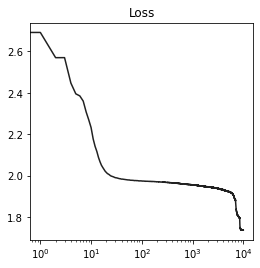

100%|██████████| 10000/10000 [2:19:31<00:00,  1.19it/s]

Model saved.
Trained on data equivalent to 10000000 solves.


In [ ]:
train(TrainConfig)
print(f"Trained on data equivalent to {TrainConfig.batch_size_per_depth * TrainConfig.num_train_steps} solves.")


## Inference

We test and compare on the DeepCubeA dataset

In [ ]:
%%capture
model.eval()

### Dataset

Download dataset from GitHub

In [ ]:
if "DeepCubeA"!=os.getcwd().split("/")[-1]:
    if not os.path.exists('DeepCubeA'):
        !git clone -q https://github.com/forestagostinelli/DeepCubeA
    %cd ./DeepCubeA/

print('\n### DeepCubeA ###')

filename = 'results/lightsout7/results.pkl'
with open(filename, 'rb') as f:
    data_Optimal = pickle.load(f)

print(data_Optimal.keys())
solutions_Optimal, times_Optimal, num_nodes_Optimal = [
    data_Optimal[e] for e in ['solutions', 'times', 'num_nodes_generated']]
len_Optimal = [len(s) for s in solutions_Optimal]
len_Optimal_count = {i: len_Optimal.count(
    i) for i in range(min(len_Optimal), max(len_Optimal))}

print('No. of cases:', len(len_Optimal))

%cd ../

/content/DeepCubeA

### DeepCubeA ###
dict_keys(['states', 'solutions', 'paths', 'times', 'num_nodes_generated'])
No. of cases: 500
/content


In [ ]:
# in LightsOut, applying the solution is equivalent to undoing it.
test_scrambles = solutions_Optimal

### Greedy search

In [ ]:
def beam_search(
        env,
        model,
        max_depth,
        beam_width,
        __eval = 'logits',
        skip_redundant_moves=True,
    ):
    """
    Best-first search algorithm.
    Input:
        env: A scrambled instance of the given environment. 
        beam_width: Number of top solutions to return per depth.
        max_depth: Maximum depth of the search tree.
        __eval: Evaluation method for sorting nodes to expand, based on DNN outputs: 'softmax', 'logits', or 'cumprod'. 
        skip_redundant_moves: If True, skip redundant moves.
        ...
    Output: 
        if solved successfully:
            True, {'solutions':solution path, "num_nodes":number of nodes expanded, "times":time taken to solve}
        else:
            False, None
    """
    with torch.no_grad():
        # metrics
        num_nodes, time_0 = 0, time.time()
        candidates = [
            {"state":deepcopy(env.state), "path":[], "value":1.}
        ] # list of dictionaries

        for depth in range(max_depth+1):
            # TWO things at a time for every candidate: 1. check if solved & 2. add to batch_x
            batch_x = np.zeros((len(candidates), env.state.shape[-1]), dtype=np.int64)
            for i,c in enumerate(candidates):
                c_path, env.state = c["path"], c["state"]
                if c_path:
                    env.finger(c_path[-1])
                    num_nodes += 1
                    if env.is_solved():
                        return True, {'solutions':c_path, "num_nodes":num_nodes, "times":time.time()-time_0}
                batch_x[i, :] = env.state

            # after checking the nodes expanded at the deepest    
            if depth==max_depth:
                print("Solution not found.")
                return False, None

            # make predictions with the trained DNN
            batch_x = torch.from_numpy(batch_x).to(device)
            batch_p = model(batch_x).to("cpu").detach().numpy()

            # loop over candidates
            candidates_next_depth = []  # storage for the depth-level candidates storing (path, value, index).
            for i, c in enumerate(candidates):
                c_path = c["path"]
                value_distribution = batch_p[i, :] # output logits for the given state
                if __eval in ["softmax","cumprod"]:
                    value_distribution = softmax(value_distribution)
                    if __eval=="cumprod":
                        value_distribution *= c["value"] # multiply the cumulative probability so far of the expanded path

                for m, value in zip(env.moves_inference, value_distribution): # iterate over all possible moves.
                    # predicted value to expand the path with the given move.

                    if skip_redundant_moves:
                        # logically meaningless operation
                        if m in c_path:
                            continue

                    # add to the next-depth candidates unless 'continue'd.
                    candidates_next_depth.append({
                        'state':deepcopy(c['state']),
                        "path": c_path+[m],
                        "value":value,
                    })

            # sort potential paths by expected values and renew as 'candidates'
            candidates = sorted(candidates_next_depth, key=lambda item: -item['value'])
            # if the number of candidates exceed that of beam width 'beam_width'
            candidates = candidates[:beam_width]

def greedy_search(env, model, max_depth, skip_redundant_moves=True):
    return beam_search(env, model, max_depth, 1, __eval = 'logits', skip_redundant_moves=True)


### Solve

100%|██████████| 500/500 [00:15<00:00, 32.53it/s]


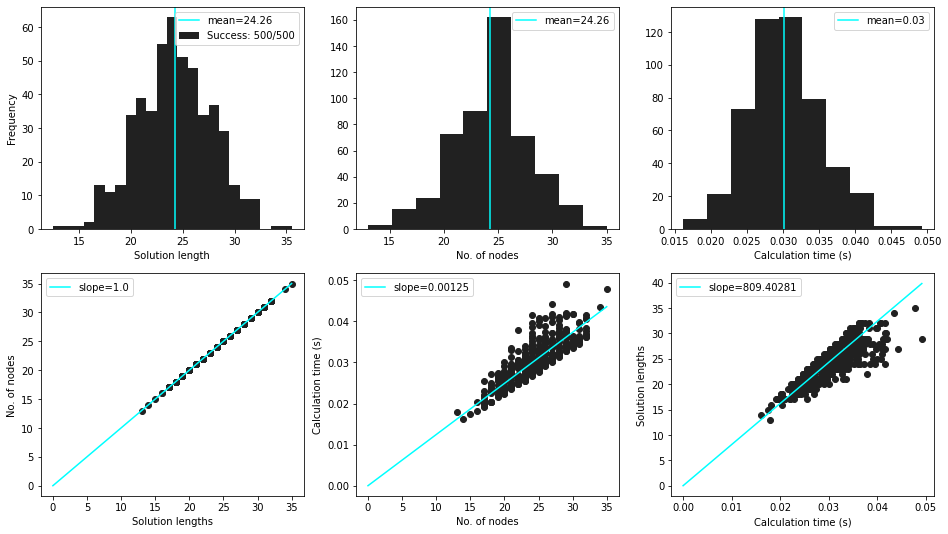

In [ ]:
result_all = {
    "solutions":[],
    "num_nodes":[],
    "times":[]
}
for scramble in tqdm(test_scrambles, position=0):
    # reset and scramble
    env.reset()
    for scramble_move in scramble:
        env.finger(scramble_move)
    # solve
    success, result = greedy_search(env, model, SearchConfig.max_depth)
    if success:
        for k in result_all.keys():
            result_all[k].append(result[k])

plot_result(*result_all.values())
